## Take home assignment

Defining   an   "adopted   user"   as   a   user   who   has   logged   into   the   product   on   three   separate
days   in   at   least   one   seven­day   period ,   identify   which   factors   predict   future   user
adoption . We   suggest   spending   1­2   hours   on   this,   but   you're   welcome   to   spend   more   or   less.
Please   send   us   a   brief   writeup   of   your   findings   (the   more   concise,   the   better   ­­   no   more
than   one   page),   along   with   any   summary   tables,   graphs,   code,   or   queries   that   can   help
us   understand   your   approach.   Please   note   any   factors   you   considered   or   investigation
you   did,   even   if   they   did   not   pan   out.   Feel   free   to   identify   any   further   research   or   data
you   think   would   be   valuable

In [5]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import scipy.stats as st
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics

# utils
from sklearn.model_selection import train_test_split

In [6]:
user_engagement=pd.read_csv("takehome_user_engagement.csv")
users=pd.read_csv("takehome_users.csv",encoding='iso-8859-1')

# EDA

In [7]:
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [8]:
user_engagement.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [9]:
user_engagement['time_stamp']=pd.to_datetime(user_engagement['time_stamp'])
user_engagement.dtypes

time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object

In [10]:
num_users=(user_engagement["user_id"].nunique())
print(num_users)
num_visited=user_engagement["user_id"].value_counts()

8823


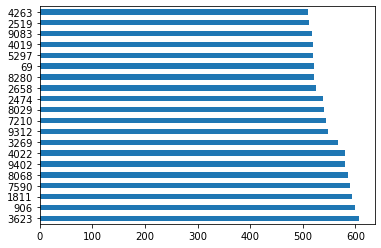

In [11]:
user_engagement["user_id"].value_counts(sort=True, ascending=False)[:20].plot(kind='barh')

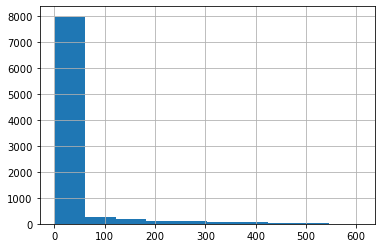

In [12]:
user_engagement["user_id"].value_counts().hist()

# Adopt users
### logged into the product on three separate days in at least one seven day period

In [13]:
# for each week, check how many times users logged into product
df=user_engagement
df['wk'] = df['time_stamp'].dt.week
df=df.groupby(['wk','user_id'])['time_stamp'].count().reset_index(name="freq")

result = df[df.freq >= 3]

# only user ids matching criteria
user_ids = result.user_id.tolist()
print(len(user_ids))
df.head()

29771


<ipython-input-13-790f6c8152df>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['wk'] = df['time_stamp'].dt.week


,wk,user_id,freq
0,1,2,1
1,1,10,5
2,1,42,4
3,1,43,1
4,1,46,1


In [14]:
result.head()

,wk,user_id,freq
1,1,10,5
2,1,42,4
5,1,63,7
6,1,69,10
7,1,81,3


In [15]:
print(result["user_id"].nunique())
adopt_users=result["user_id"].unique()
print(len(adopt_users))

1445
1445


In [16]:
print(df['user_id'].nunique())
adopt_users = df[df.freq >= 3]['user_id'].unique()
print(len(adopt_users))

8823
1445


In [17]:
non_adopt_result=df[~df.user_id.isin(adopt_users)]
non_adopt_users = non_adopt_result["user_id"].unique()
print(len(non_adopt_users))

7378


## There are about 16.3% of users are adopt users,  1445 adopt users out of 8823 users 
#### 

# Let look at the users csv
## 

In [18]:
print(users.shape)
users.head()


(12000, 10)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [19]:

users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [20]:
users.isnull().values.any()

True

In [21]:
users.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [22]:
users.nunique()

object_id                     12000
creation_time                 11996
name                          11355
email                         11980
creation_source                   5
last_session_creation_time     8821
opted_in_to_mailing_list          2
enabled_for_marketing_drip        2
org_id                          417
invited_by_user_id             2564
dtype: int64

In [23]:
df_users=users
df_users.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

In [24]:
df_users['invited_by_user_id'].fillna(-1, inplace=True)
df_users['invited_by_user_id']=df_users['invited_by_user_id'].astype('int64',copy=False)

In [25]:
tmp_mean=df_users['last_session_creation_time'].mean()
df_users['last_session_creation_time'].fillna(tmp_mean, inplace=True)

In [26]:
df_users_dummies=pd.get_dummies(df_users, columns=["creation_source"],drop_first=False)

In [27]:
df_users_dummies.rename(columns={"object_id":"user_id"}, inplace=True)

In [28]:
df_users_dummies.head()

,user_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,10803,1,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316,0,1,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1.363735e+09,0,0,94,1525,0,1,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,1.369210e+09,0,0,1,5151,1,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,1.358850e+09,0,0,193,5240,1,0,0,0,0


In [29]:
df_users_dummies.dtypes

user_id                                 int64
creation_time                          object
name                                   object
email                                  object
last_session_creation_time            float64
opted_in_to_mailing_list                int64
enabled_for_marketing_drip              int64
org_id                                  int64
invited_by_user_id                      int64
creation_source_GUEST_INVITE            uint8
creation_source_ORG_INVITE              uint8
creation_source_PERSONAL_PROJECTS       uint8
creation_source_SIGNUP                  uint8
creation_source_SIGNUP_GOOGLE_AUTH      uint8
dtype: object

## Classication

In [30]:
all_users=list(adopt_users)+list(non_adopt_users)
print(all_users[:20])

[10, 42, 63, 69, 81, 82, 87, 146, 153, 160, 168, 197, 202, 203, 209, 230, 245, 263, 297, 310]


In [31]:
# only consider users in engegment
df_cleaned=df_users_dummies[df_users_dummies.user_id.isin(all_users)]

In [32]:
df_cleaned['class']=0
df_cleaned['class'][df_users_dummies.user_id.isin(adopt_users)]=1

<ipython-input-32-f8943eaec339>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['class']=0
<ipython-input-32-f8943eaec339>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['class'][df_users_dummies.user_id.isin(adopt_users)]=1
/Users/yuenyeelo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [33]:
df_cleaned['class'].value_counts()

0    7378
1    1445
Name: class, dtype: int64

In [34]:
X=df_cleaned.drop(['class','user_id','creation_time','name','email'],axis=1)
y=df_cleaned['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# baseline logistic regression
def run_LR(X_train,y_train, X_test, y_test):
    LR = LogisticRegression()
    LR.fit(X_train,y_train)
    sc_train=LR.score(X_train, y_train, sample_weight=None)
    sc_test=LR.score(X_test, y_test, sample_weight=None)
    
    #print(sc_train, sc_test)
    y_pred=LR.predict(X_test)
    #print(y_test.shape)
    #print(y_pred.shape)
    print('accuracy:', LR.score( X_test, y_test))
    return LR

In [49]:
LR=run_LR(X_train,y_train, X_test, y_test)

accuracy: 0.8271954674220963


In [63]:
def run_RFC(X_train,y_train, X_test, y_test):
    regr = RandomForestClassifier(max_depth=4, random_state=0)
    regr.fit(X_train, y_train)
    sc_train=regr.score(X_train, y_train, sample_weight=None)
    sc_test=regr.score(X_test, y_test, sample_weight=None)
    print("Score_training data " , sc_train) 
    print("Score_testing data " , sc_test)
    
    y_pred=regr.predict(X_test)
    print('accuracy:', regr.score( X_test, y_test))
    

    return regr

In [64]:
regr=run_RFC(X_train,y_train, X_test, y_test)

Score_training data  0.9135732502125248
Score_testing data  0.8923512747875354
accuracy: 0.8923512747875354


In [65]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
    return fi_df

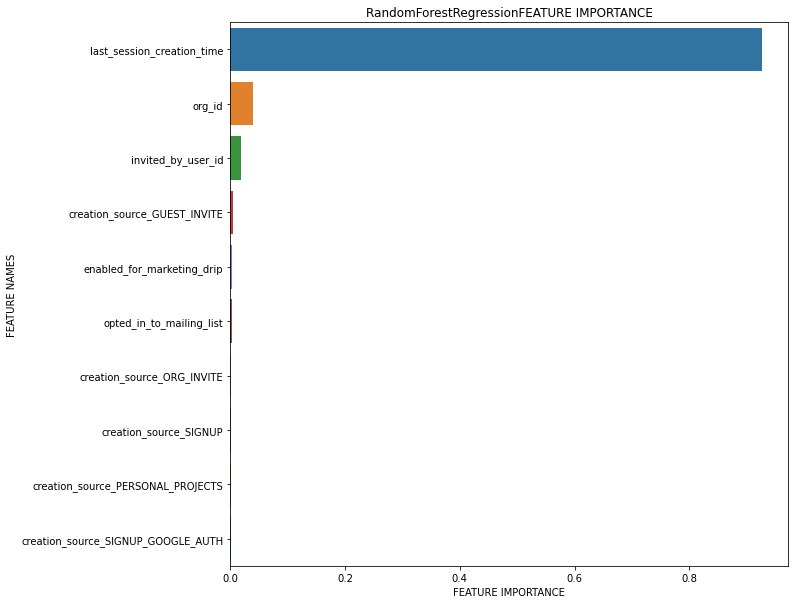

In [66]:
importances = regr.feature_importances_
features=X.columns
features_df=plot_feature_importance(importances,features,'RandomForestRegression')

In [69]:
# GradientBoostingClassifier
def run_GBC(X_train,y_train, X_test, y_test):
    params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.05}
    GBC = GradientBoostingClassifier(**params)
    GBC.fit(X_train, y_train)
    sc_train=GBC.score(X_train, y_train, sample_weight=None)
    sc_test=GBC.score(X_test, y_test, sample_weight=None)
    
    print("Score_training data " , sc_train) 
    print("Score_testing data " , sc_test)
    y_pred=GBC.predict(X_test)
    print('accuracy:', GBC.score( X_test, y_test))
    
    return GBR

In [70]:
GBR=run_GBC(X_train,y_train, X_test, y_test)

Score_training data  0.9222159251912723
Score_testing data  0.8968838526912182
accuracy: 0.8968838526912182


#### From the results, we can see that the  GradientBoostingClassifier gives the best results in this classification task, with accuracy 89.6%, while our baseline logistic regression, accuracy is 82.7%. The fe



In [ ]:
### Further work

Some other information may be useful:
- geolocation , zip code, for example, people in the cities may like to use facebook more
- number of people likes the user posts , users maybe more enage if he/she have many friends likes his/her posts
- number of likes, comments user given
- number of friends user have